In [1]:
'''
Inspired from https://github.com/GunhoChoi/Kind-PyTorch-Tutorial/blob/master/07_Denoising_Autoencoder/Denoising_Autoencoder.ipynb
'''

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io, transform
import os
import pickle
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
filename='data/NZ_del20.pkl' #deleted 20% images with lower NZ count
with open(filename, 'rb') as handle:
    subset_dict=pickle.load(handle)
images_list=subset_dict['images']
del subset_dict

In [5]:
#reshape images to same dimensions
from skimage.transform import resize
data_list=[]
for gray_img in images_list:
    img=resize(gray_img, (120,240), anti_aliasing=True, mode='constant') #resize all images to 120x240
    img=np.asarray(img, dtype=float)
    data_list.append(img)

images_array=np.asarray(data_list)
del data_list

In [6]:
class Comb_Dataset(Dataset):

    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        sample = {'image': image}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        transformed_image = torch.from_numpy(image)
        unsqueezed_image = torch.unsqueeze(transformed_image,0) #add a dimension with value 1 to represent colour
        float_img=unsqueezed_image.float()
        return {'image': float_img}


In [7]:
#preparing the data and batches
transformed_data = Comb_Dataset(images = images_array, 
                                transform = ToTensor())
del images_array

In [88]:
class SmallEncoder(nn.Module):
    def __init__(self):
        super(SmallEncoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.layer3 = nn.Sequential(
                        nn.Conv2d(16,16,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
                        nn.Conv2d(16,1,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(1),
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out, indices1 = self.pool(out)
        out = self.layer2(out)
        out, indices2 = self.pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        return out, [indices1, indices2]

encoder = SmallEncoder().to(device)


class SmallDecoder(nn.Module):
    def __init__(self):
        super(SmallDecoder,self).__init__()
        self.first_conv = nn.Sequential(
                        nn.ConvTranspose2d(1,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.unpool = nn.MaxUnpool2d(2,2)
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(16,1,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(1),
        )
        
    def forward(self,x, indices):
        out = x.view(x.size(0),1,30,60)
        out = self.first_conv(out)
        out = self.unpool(out, indices[1])
        out = self.layer1(out)
        out = self.unpool(out, indices[0])
        out = self.layer2(out)
        out = self.layer3(out)
        return out

decoder = SmallDecoder().to(device)

In [8]:
# Encoder 

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.layer3 = nn.Sequential(
                        nn.Conv2d(16,16,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
                        nn.Conv2d(16,1,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(1),
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out, indices1 = self.pool(out)
        out = self.layer2(out)
        out, indices2 = self.pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        return out, [indices1, indices2]

encoder = Encoder().to(device)


In [9]:
# Decoder 

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.first_conv = nn.Sequential(
                        nn.ConvTranspose2d(1,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.unpool = nn.MaxUnpool2d(2,2)
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(16,1,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(1),
        )
        
    def forward(self,x, indices):
        out = x.view(x.size(0),1,30,60)
        out = self.first_conv(out)
        out = self.unpool(out, indices[1])
        out = self.layer1(out)
        out = self.unpool(out, indices[0])
        out = self.layer2(out)
        out = self.layer3(out)
        return out

decoder = Decoder().to(device)

In [10]:
random_seed = 1
torch.backends.cudnn.enabled = False #setting off non-deterministic algorithms
torch.manual_seed(random_seed)

# Set Hyperparameters

epoch = 10
batch_size =100
learning_rate = 0.01
cur_epoch=0

parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)


#preparing the data and batches
train_loader = torch.utils.data.DataLoader(transformed_data, batch_size=batch_size, shuffle=True)
del transformed_data

In [11]:
def add_noise(batch_img):
    shape=batch_img.size()
    for i in range(shape[0]):
        length=shape[2]*shape[3]
        idx=np.ones(length)
        random_idx=np.random.choice(np.arange(length), int(length*0.3))
        idx[random_idx]=0
        idx=idx.reshape([shape[2],shape[3]])
        batch_img[i,0,:,:]=batch_img[i,0,:,:]*torch.from_numpy(idx).float().to(device)
    return batch_img
    

Train Epoch: 1 [0/14629 (0%)]	Loss: 0.984311
Train Epoch: 1 [1000/14629 (7%)]	Loss: 0.766034
Train Epoch: 1 [2000/14629 (14%)]	Loss: 0.606951
Train Epoch: 1 [3000/14629 (20%)]	Loss: 0.467988
Train Epoch: 1 [4000/14629 (27%)]	Loss: 0.352900
Train Epoch: 1 [5000/14629 (34%)]	Loss: 0.261608
Train Epoch: 1 [6000/14629 (41%)]	Loss: 0.187783
Train Epoch: 1 [7000/14629 (48%)]	Loss: 0.134973
Train Epoch: 1 [8000/14629 (54%)]	Loss: 0.095949
Train Epoch: 1 [9000/14629 (61%)]	Loss: 0.064249
Train Epoch: 1 [10000/14629 (68%)]	Loss: 0.042324
Train Epoch: 1 [11000/14629 (75%)]	Loss: 0.026916
Train Epoch: 1 [12000/14629 (82%)]	Loss: 0.018010
Train Epoch: 1 [13000/14629 (88%)]	Loss: 0.011011
Train Epoch: 1 [14000/14629 (95%)]	Loss: 0.005814


/home/desgab/.local/easybuild/software/2017/Core/miniconda3/4.3.27/envs/comp551/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/desgab/.local/easybuild/software/2017/Core/miniconda3/4.3.27/envs/comp551/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 2 [0/14629 (0%)]	Loss: 0.004609
Train Epoch: 2 [1000/14629 (7%)]	Loss: 0.002341
Train Epoch: 2 [2000/14629 (14%)]	Loss: 0.001585
Train Epoch: 2 [3000/14629 (20%)]	Loss: 0.000878
Train Epoch: 2 [4000/14629 (27%)]	Loss: 0.000550
Train Epoch: 2 [5000/14629 (34%)]	Loss: 0.000304
Train Epoch: 2 [6000/14629 (41%)]	Loss: 0.000265
Train Epoch: 2 [7000/14629 (48%)]	Loss: 0.000200
Train Epoch: 2 [8000/14629 (54%)]	Loss: 0.000174
Train Epoch: 2 [9000/14629 (61%)]	Loss: 0.000187
Train Epoch: 2 [10000/14629 (68%)]	Loss: 0.000196
Train Epoch: 2 [11000/14629 (75%)]	Loss: 0.000144
Train Epoch: 2 [12000/14629 (82%)]	Loss: 0.000143
Train Epoch: 2 [13000/14629 (88%)]	Loss: 0.000179
Train Epoch: 2 [14000/14629 (95%)]	Loss: 0.000177
tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 3 [0/14629 (0%)]	Loss: 0.000144
Train Epoch: 3 [1000/14629 (7%)]	Loss: 0.000148
Train Epoch: 3 [2000/14629 (14%)]	Loss: 0.000214
Train

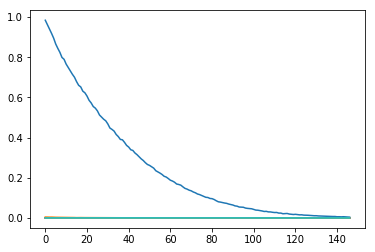

In [12]:
# train encoder and decoder

for i in range(cur_epoch, epoch):
    loss_followup=[]
    for batch_idx, data in enumerate(train_loader):
        image = data["image"].to(device)
        image_n = add_noise(image)
        optimizer.zero_grad()
        output, indices = encoder(image_n)
        output = decoder(output, indices)
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        loss_followup.append(loss.item())
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                i+1, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    plt.plot(loss_followup)

                
    torch.save([encoder,decoder, i+1],'./data/deno_autoencoder.pkl')
    print(loss)

In [94]:
# save and load model

try:
    encoder, decoder, cur_epoch = torch.load('./data/deno_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass



--------model restored--------



In [57]:
enc_output, indices = encoder(image_n[:10,:,:,:])
dec_output = decoder(enc_output, indices)


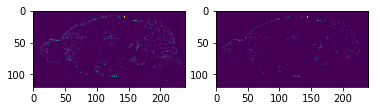

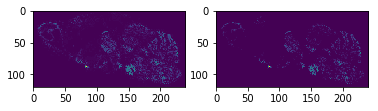

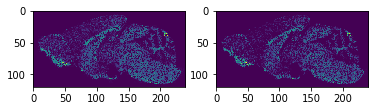

In [62]:
img=image.cpu().detach().numpy()
out=dec_output.cpu().detach().numpy()
fig,[ax1,ax2]=plt.subplots(1,2)
ax1.imshow(img[2,0,:,:])
ax2.imshow(out[2,0,:,:])

fig,[ax1,ax2]=plt.subplots(1,2)
ax1.imshow(img[1,0,:,:])
ax2.imshow(out[1,0,:,:])

fig,[ax1,ax2]=plt.subplots(1,2)
ax1.imshow(img[9,0,:,:])
ax2.imshow(out[9,0,:,:])
